Weather Forecasting with 4 features using historical data via TDNN

In [113]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import math

import torch
import torch.nn as nn
import torch.optim as optim

Key parameters:

In [114]:
learning_rate = 1e-2  # learning rate
window_size = 30       # window size
pred_size = 1         # prediction step
num_features = 4      # number of features per vector


In [115]:
# Model definition

class TDNN(nn.Module):
    def __init__(self, input_size, window_size, output_size):
        super(TDNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.fc = nn.Linear(32 * window_size, output_size)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [116]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [117]:
# Function to Create Sequences
def create_sequences(data, window_size=10):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size]) # 1..10, 2..11, 3..12, ......
        labels.append(data[i+window_size])
    return np.array(sequences), np.array(labels)

In [118]:
# Link to 6 weather datasets
url_ottawa = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_ottawa_daily.csv"
url_ottawa_south = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_ottawasouth_daily.csv"
#url_gatineau = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_gatineau_daily.csv"
#url_chelsea = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_chelsea_daily.csv"
#url_kemptville = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_kemptville_daily.csv"
#url_renfrew = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_renfrew_daily.csv"

# Load data
url = url_ottawa
data = pd.read_csv(url)

# Convert date and filter data
data['date'] = pd.to_datetime(data['date'])
filtered_data = data[(data['date'].dt.month >= 5) & (data['date'].dt.month <= 11)]
filtered_data = filtered_data[(filtered_data['date'].dt.year >= 2013) & (filtered_data['date'].dt.year <= 2023)]

# Select relevant columns
selected_columns = ['avg_hourly_temperature', 'precipitation', 'solar_radiation', 'avg_hourly_pressure_station']
filtered_data_train = filtered_data[(filtered_data['date'].dt.year < 2023)]
filtered_data_test = filtered_data[(filtered_data['date'].dt.year == 2023)]
#final_data = filtered_data[selected_columns]
final_data = filtered_data_train[selected_columns]
final_data_test = filtered_data_test[selected_columns]

# Handle Missing Values
#final_data = final_data.fillna(method='ffill')  # option 1: forward fill
final_data = final_data.dropna()  # option 2: drop data with null values
final_data_test = final_data_test.dropna()

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(final_data)
#scaled_data = pd.DataFrame(scaled_data, columns=final_data.columns)

# do the same for test data
scaled_data_test = scaler.fit_transform(final_data_test)
#scaled_data_test = pd.DataFrame(scaled_data_test, columns=final_data_test.columns)

#scaled_data_test = scaler.fit_transform(final+)

# Split the data into training and testing sets
#train_data = scaled_data[(filtered_data['date'].dt.year < 2023)]
#test_data = scaled_data[(filtered_data['date'].dt.year == 2023)]
train_data = scaled_data
test_data = scaled_data_test




<ipython-input-118-f7220ec93071>:11: DtypeWarning: Columns (46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url)


In [119]:
# Prepare data for model input

#input_data = series_to_supervised(train_data.values, n_in=window_size, n_out=pred_size)
input_data = series_to_supervised(train_data, n_in=window_size, n_out=pred_size)

input_features = input_data.iloc[:, :-num_features].values
output_features = input_data.iloc[:, -num_features:].values

In [120]:
# Adjust series_to_supervised output to correct shape for Conv1d
def reshape_input_for_conv1d(input_features, window_size, num_features):
    # Reshape from (samples, features*window_size) to (samples, num_features, window_size)
    #return input_features.reshape(-1, window_size, num_features)
    return input_features.reshape(-pred_size, window_size, num_features)

In [121]:
#num_features = 4
# Reshape input_features for the Conv1D layer
input_features_reshaped = reshape_input_for_conv1d(input_features, window_size, num_features)

# Convert datasets to PyTorch tensors
X_train_tensor = torch.tensor(input_features_reshaped, dtype=torch.float32)
#X_train_tensor = torch.tensor(input_features, dtype=torch.float32)
y_train_tensor = torch.tensor(output_features, dtype=torch.float32)



In [122]:
#print(X_train_tensor)


In [123]:
# Convert datasets to PyTorch tensors
#X_train_tensor = torch.tensor(input_features, dtype=torch.float32)
#y_train_tensor = torch.tensor(output_features, dtype=torch.float32)

# DataLoader setup
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Model initialization
#model = TDNN(input_size=4, window_size=window_size, output_size=4)
model = TDNN(input_size=num_features, window_size=window_size, output_size=num_features)

# Loss and optimizer
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # default: 0.001 (1e-4)


# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/50], Loss: 0.0373
Epoch [2/50], Loss: 0.0271
Epoch [3/50], Loss: 0.0177
Epoch [4/50], Loss: 0.0224
Epoch [5/50], Loss: 0.0149
Epoch [6/50], Loss: 0.0234
Epoch [7/50], Loss: 0.0184
Epoch [8/50], Loss: 0.0213
Epoch [9/50], Loss: 0.0186
Epoch [10/50], Loss: 0.0228
Epoch [11/50], Loss: 0.0155
Epoch [12/50], Loss: 0.0194
Epoch [13/50], Loss: 0.0153
Epoch [14/50], Loss: 0.0197
Epoch [15/50], Loss: 0.0205
Epoch [16/50], Loss: 0.0207
Epoch [17/50], Loss: 0.0193
Epoch [18/50], Loss: 0.0251
Epoch [19/50], Loss: 0.0178
Epoch [20/50], Loss: 0.0198
Epoch [21/50], Loss: 0.0152
Epoch [22/50], Loss: 0.0126
Epoch [23/50], Loss: 0.0180
Epoch [24/50], Loss: 0.0207
Epoch [25/50], Loss: 0.0163
Epoch [26/50], Loss: 0.0167
Epoch [27/50], Loss: 0.0172
Epoch [28/50], Loss: 0.0216
Epoch [29/50], Loss: 0.0244
Epoch [30/50], Loss: 0.0144
Epoch [31/50], Loss: 0.0153
Epoch [32/50], Loss: 0.0152
Epoch [33/50], Loss: 0.0157
Epoch [34/50], Loss: 0.0129
Epoch [35/50], Loss: 0.0131
Epoch [36/50], Loss: 0.0152
E

Mean Absolute Error: 1384.5906
Root Mean Square Error: 3260.6892
Temperature - Mean Absolute Error: 3.7228
Temperature - Root Mean Square Error: 4.7131
Precipitation - Mean Absolute Error: 3.4313
Precipitation - Root Mean Square Error: 6.4993
Solar Radiation - Mean Absolute Error: 5530.6129
Solar Radiation - Root Mean Square Error: 6521.3735
Pressure - Mean Absolute Error: 0.5954
Pressure - Root Mean Square Error: 0.7556


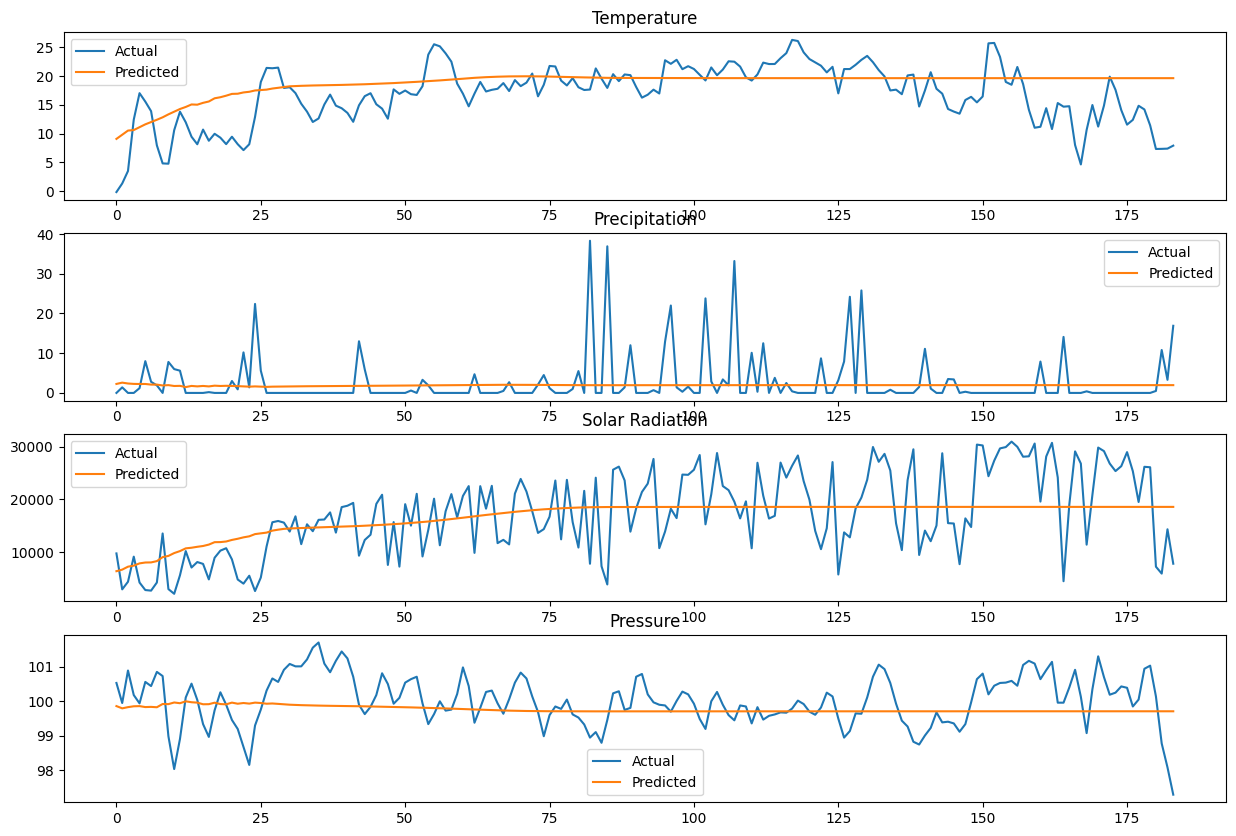

In [124]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicting recursively for 2023
model.eval()
test_input = test_data[:window_size]  # first two weeks of 2023
predictions = []

for i in range(len(test_data) - window_size):
    test_input_tensor = torch.tensor(test_input.reshape(1, window_size, -1), dtype=torch.float32)  # need to modify if pred_size is changed
    with torch.no_grad():
        pred = model(test_input_tensor)
        pred = pred.numpy()
    predictions.append(pred[0])
    # Slide window by removing first and adding predicted
    test_input = np.vstack([test_input[1:], pred])

# Calculate errors
predictions = np.array(predictions)
true_values = test_data[window_size:]

# Inverse transform the scaled predictions and actual values
predictions_inverse = scaler.inverse_transform(predictions)
true_values_inverse = scaler.inverse_transform(true_values)

# Calculate errors on the original scale
mae = mean_absolute_error(true_values_inverse, predictions_inverse)
rmse = math.sqrt(mean_squared_error(true_values_inverse, predictions_inverse))

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Square Error: {rmse:.4f}')

# Optional: plotting the results
import matplotlib.pyplot as plt

# Initialize arrays to hold MAE and RMSE values
maes = []
rmses = []

# Plotting the results
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['Temperature', 'Precipitation', 'Solar Radiation', 'Pressure']):
    plt.subplot(4, 1, i+1)
    plt.plot(true_values_inverse[:, i], label='Actual')
    plt.plot(predictions_inverse[:, i], label='Predicted')
    plt.title(feature)
    plt.legend()

    # Calculate MAE and RMSE for this feature
    mae = mean_absolute_error(true_values_inverse[:, i], predictions_inverse[:, i])
    rmse = math.sqrt(mean_squared_error(true_values_inverse[:, i], predictions_inverse[:, i]))
    maes.append(mae)
    rmses.append(rmse)

    # Print MAE and RMSE for this feature
    print(f'{feature} - Mean Absolute Error: {mae:.4f}')
    print(f'{feature} - Root Mean Square Error: {rmse:.4f}')
#plt.tight_layout()
plt.show()


Temperature (First 14 Days) - Mean Absolute Error: 5.0931
Temperature (First 14 Days) - Root Mean Square Error: 5.7982
Precipitation (First 14 Days) - Mean Absolute Error: 2.4874
Precipitation (First 14 Days) - Root Mean Square Error: 3.0188
Solar Radiation (First 14 Days) - Mean Absolute Error: 4089.5465
Solar Radiation (First 14 Days) - Root Mean Square Error: 4442.7693
Pressure (First 14 Days) - Mean Absolute Error: 0.7130
Pressure (First 14 Days) - Root Mean Square Error: 0.8550


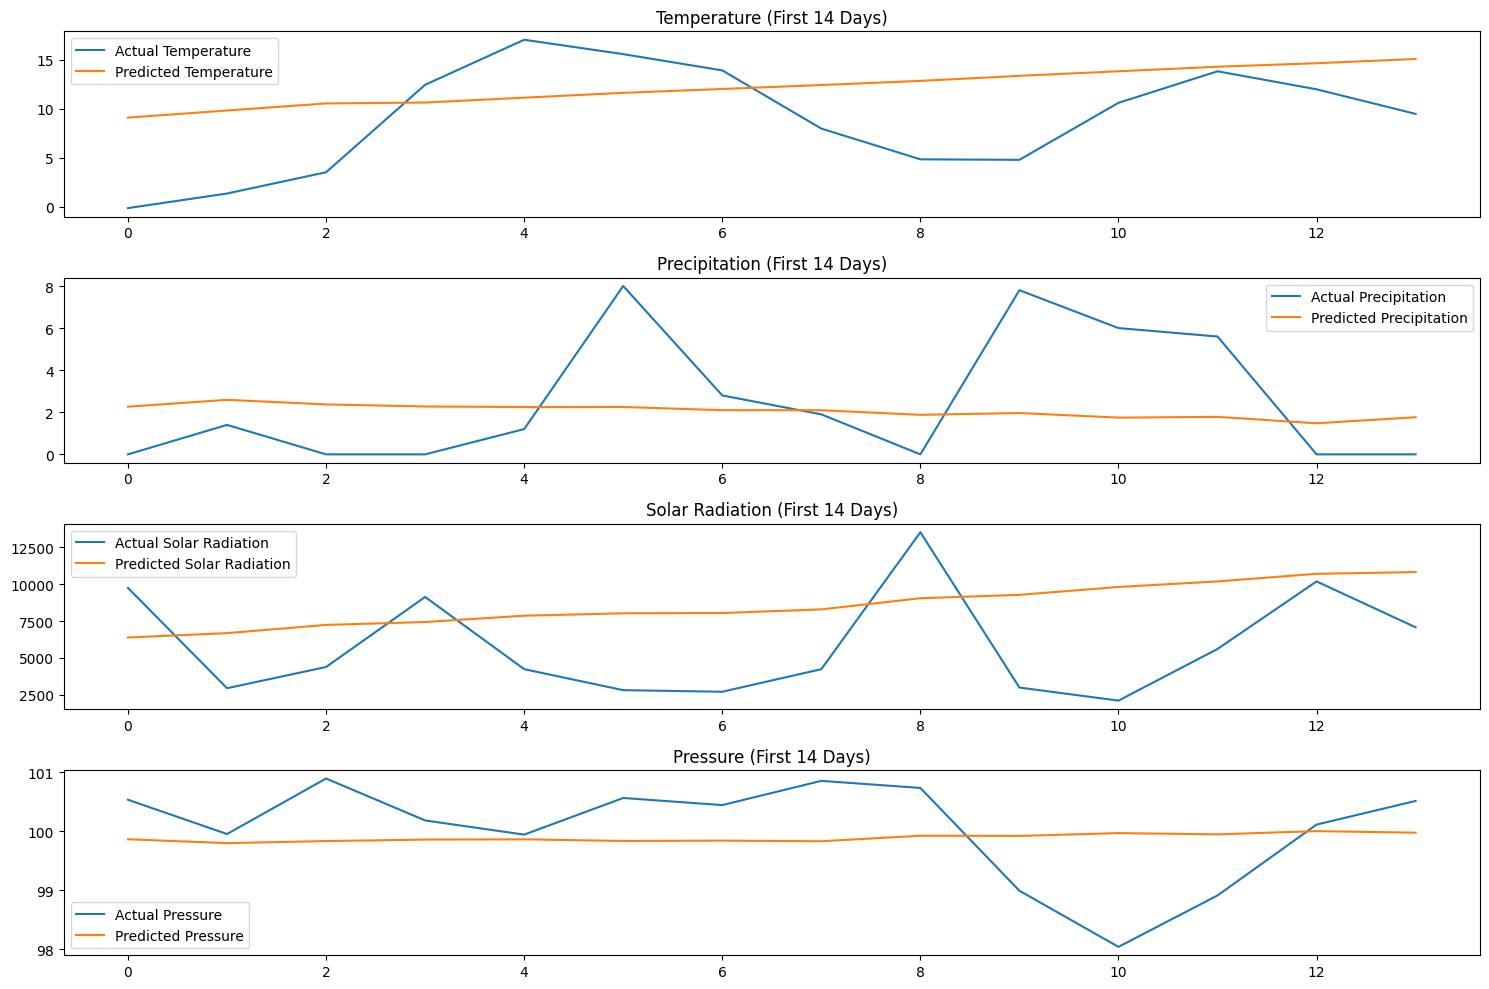

Zoomed-in MAEs: [5.093074428013392, 2.4873898846762517, 4089.5464913504466, 0.7129908970424107]
Zoomed-in RMSEs: [5.79822112016002, 3.018760055787885, 4442.769328703613, 0.8549574268450788]


In [125]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Assuming 'scaler' is your MinMaxScaler instance and you've already calculated 'predictions_inverse' and 'true_values_inverse'
# Also assuming predictions start from May and 'predictions_inverse' has already been sliced to only include prediction period from May to November

# Initialize arrays to hold MAE and RMSE values for the zoomed period
maes_zoomed = []
rmses_zoomed = []

# Plotting the results for the first 60 days and calculating errors for each feature
plt.figure(figsize=(15, 10))
features = ['Temperature', 'Precipitation', 'Solar Radiation', 'Pressure']
for i, feature in enumerate(features):
    plt.subplot(4, 1, i + 1)
    plt.plot(true_values_inverse[:14, i], label='Actual ' + feature)
    plt.plot(predictions_inverse[:14, i], label='Predicted ' + feature)
    plt.title(feature + " (First 14 Days)")
    plt.legend()

    # Calculate MAE and RMSE for this feature for the first 60 days
    mae_zoomed = mean_absolute_error(true_values_inverse[:14, i], predictions_inverse[:14, i])
    rmse_zoomed = sqrt(mean_squared_error(true_values_inverse[:14, i], predictions_inverse[:14, i]))
    maes_zoomed.append(mae_zoomed)
    rmses_zoomed.append(rmse_zoomed)

    # Print MAE and RMSE for this feature for the first 60 days
    print(f'{feature} (First 14 Days) - Mean Absolute Error: {mae_zoomed:.4f}')
    print(f'{feature} (First 14 Days) - Root Mean Square Error: {rmse_zoomed:.4f}')

plt.tight_layout()
plt.show()

# Optionally, print all zoomed MAEs and RMSEs
print("Zoomed-in MAEs:", maes_zoomed)
print("Zoomed-in RMSEs:", rmses_zoomed)


In [126]:
# Initialize arrays to hold MAE and MSE values for the first 14 days
maes_14_days = []
mses_14_days = []

# Calculate errors for each feature for the first 14 days
features = ['Temperature', 'Precipitation', 'Solar Radiation', 'Pressure']
print("Errors for the first 14 days:")
for i, feature in enumerate(features):
    # Calculate MAE and MSE for this feature for the first 14 days
    mae_14_days = mean_absolute_error(true_values_inverse[:14, i], predictions_inverse[:14, i])
    mse_14_days = mean_squared_error(true_values_inverse[:14, i], predictions_inverse[:14, i])
    maes_14_days.append(mae_14_days)
    mses_14_days.append(mse_14_days)

    # Print MAE and MSE for this feature for the first 14 days
    print(f'{feature} - Mean Absolute Error: {mae_14_days:.4f}')
    print(f'{feature} - Mean Squared Error: {mse_14_days:.4f}')

# Optionally, if you want to see the root mean square error, you can calculate it from the MSE:
rmses_14_days = [sqrt(mse) for mse in mses_14_days]
print("Root Mean Squared Errors for the first 14 days:", rmses_14_days)

Errors for the first 14 days:
Temperature - Mean Absolute Error: 5.0931
Temperature - Mean Squared Error: 33.6194
Precipitation - Mean Absolute Error: 2.4874
Precipitation - Mean Squared Error: 9.1129
Solar Radiation - Mean Absolute Error: 4089.5465
Solar Radiation - Mean Squared Error: 19738199.3081
Pressure - Mean Absolute Error: 0.7130
Pressure - Mean Squared Error: 0.7310
Root Mean Squared Errors for the first 14 days: [5.79822112016002, 3.018760055787885, 4442.769328703613, 0.8549574268450788]
